In [192]:
import pandas as pd

This blog post walks through the concept of two-level factorial designs for experimental design, the same material covered by Chapter 4 of Box and Draper's "Empirical Model-Building and Response Surfaces." 

In [193]:
from IPython.display import Image
Image(url='http://charlesreid1.com/images/empirical_models.jpg', width=300)

Box and Draper begin their discussion of different experimental design methods with the simplest type of factorial design: a full factorial design with two levels. These experimental designs are appropriate for exploratory stages.

# Two-Level Full Factorial Design

The analysis begins with a two-level, three-variable experimental design - also written $2^3$, with $n=2$ levels for each factor, $k=3$ different factors. We start by encoding each fo the three variables to something generic: $(x_1,x_2,x_3)$. A dataframe with input variable values is then populated.

In the particular case being analyzed, the 

In [194]:
inputs_labels = {'x1' : 'Length of specimen (mm)',
                 'x2' : 'Amplitude of load cycle (mm)',
                 'x3' : 'Load (g)'}

dat = [('x1',250,350),
       ('x2',8,10),
       ('x3',40,50)]

inputs_df = pd.DataFrame(dat,columns=['index','low','high'])
inputs_df = inputs_df.set_index(['index'])
inputs_df['label'] = inputs_df.index.map( lambda z : inputs_labels[z] )

inputs_df

,low,high,label
index,,,
x1,250,350,Length of specimen (mm)
x2,8,10,Amplitude of load cycle (mm)
x3,40,50,Load (g)


Next, we encode the variable values. For an arbitrary variable value $\phi_1$, the value of the variable can be coded to be between -1 and 1 according to the formula:

$$
x_i = \dfrac{ \phi_i - \mbox{avg }(\phi) }{ \mbox{span }(\phi) }
$$

where the average and the span of the variable $\phi_i$ are defined as:

$$
\mbox{avg }(\phi) = \left( \dfrac{ \phi_{\text{high}} + \phi_{\text{low}} }{2} \right)
$$

$$
\mbox{span }(\phi) = \left( \dfrac{ \phi_{\text{high}} - \phi_{\text{low}} }{2} \right)
$$


In [195]:
inputs_df['average']      = inputs_df.apply( lambda z : ( z['high'] + z['low'])/2 , axis=1)
inputs_df['span']         = inputs_df.apply( lambda z : ( z['high'] - z['low'])/2 , axis=1)

inputs_df['encoded_low']  = inputs_df.apply( lambda z : ( z['low']  - z['average'] )/( z['span'] ), axis=1)
inputs_df['encoded_high'] = inputs_df.apply( lambda z : ( z['high'] - z['average'] )/( z['span'] ), axis=1)

inputs_df = inputs_df.drop(['average','span'],axis=1)

inputs_df

,low,high,label,encoded_low,encoded_high
index,,,,,
x1,250,350,Length of specimen (mm),-1,1
x2,8,10,Amplitude of load cycle (mm),-1,1
x3,40,50,Load (g),-1,1


# The Heart of the Matter: Designing the Experiment

While everything preceding this point is important to state, to make sure we're being consistent and clear about our problem statement and assumptions, nothing preceding this point is particularly important to understanding how experimental design works. This is simply illustrating the process of transforming one's problem from a problem-specific problem space to a more general problem space.

Now Box and Draper present the results of the $2^3$ factorial experiment. The observed variable is number of cycles to failure, which is more conveniently cast as a logarithm. 

Each observation data point consists of three input variable values and an output variable value, $(x_1, x_2, x_3, y)$. The input variable values are the full range of input combinations:

In [196]:
import itertools
encoded_inputs = list( itertools.product([-1,1],[-1,1],[-1,1]) )
encoded_inputs

[(-1, -1, -1),
 (-1, -1, 1),
 (-1, 1, -1),
 (-1, 1, 1),
 (1, -1, -1),
 (1, -1, 1),
 (1, 1, -1),
 (1, 1, 1)]

In [197]:
results = [(-1, -1, -1, 674),
           ( 1, -1, -1, 3636),
           (-1,  1, -1, 170),
           ( 1,  1, -1, 1140),
           (-1, -1,  1, 292),
           ( 1, -1,  1, 2000),
           (-1,  1,  1, 90),
           (  1, 1,  1, 360)]

results_df = pd.DataFrame(results,columns=['x1','x2','x3','y'])
results_df['logy'] = results_df['y'].map( lambda z : log10(z) )
results_df

,x1,x2,x3,y,logy
0,-1,-1,-1,674,2.828660
1,1,-1,-1,3636,3.560624
2,-1,1,-1,170,2.230449
3,1,1,-1,1140,3.056905
4,-1,-1,1,292,2.465383
5,1,-1,1,2000,3.301030
6,-1,1,1,90,1.954243
7,1,1,1,360,2.556303


Remember that the encoded levels in the dataframe can be converted back to their normal values to show what experiments must be run:

In [198]:
#print results_df
#print inputs_df.ix['x1']['label']
#print inputs_df.ix['x1']['low']
#print inputs_df.ix['x1']['high']

real_experiment = results_df

var_labels = []
for var in ['x1','x2','x3']:
    var_label = inputs_df.ix[var]['label']
    var_labels.append(var_label)
    real_experiment[var_label] = results_df.apply(
        lambda z : inputs_df.ix[var]['low'] if z[var]<0 else inputs_df.ix[var]['high'] , 
        axis=1)

print "The values of each real variable in the experiment:"
print ""
real_experiment[var_labels]

The values of each real variable in the experiment:



,Length of specimen (mm),Amplitude of load cycle (mm),Load (g)
0,250,8,40
1,350,8,40
2,250,10,40
3,350,10,40
4,250,8,50
5,350,8,50
6,250,10,50
7,350,10,50


-----

Now we compute the main effects of each variable using the results of the experimental design. We'll use some shorthand Pandas functions to compute these averages: the groupby function, which groups rows of a dataframe according to some condition (in this case, the value of our variable of interest $x_i$).

In [199]:
# Compute the mean effect of the factor on the response,
# conditioned on each variable
labels = ['x1','x2','x3']

main_effects = {}
for key in labels:
    
    effects = results_df.groupby(key)['logy'].mean()

    main_effects[key] = sum( [i*effects[i] for i in [-1,1]] )

main_effects

{'x1': 0.7490317608790833,
 'x2': -0.58944945881907218,
 'x3': -0.34991992162024621}

Next, we use a similar strategy to compute two-way and three-way interaction effects between variables. We can use the ```itertools``` library to create our variable combinations.

We'll use the Pandas groupby function again, grouping by two variables. 

In [200]:
import itertools

twoway_labels = list(itertools.combinations(labels, 2))

twoway_effects = {}
for key in twoway_labels:
    
    effects = results_df.groupby(key)['logy'].mean()
    
    twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])

    # This somewhat hairy one-liner takes the mean of a set of sum-differences
    #twoway_effects[key] = mean([  sum([ i*effects[i][j] for i in [-1,1] ]) for j in [-1,1]  ])

twoway_effects

{('x1', 'x2'): -0.034773800236002961,
 ('x1', 'x3'): -0.030178193107320839,
 ('x2', 'x3'): -0.038484459633821189}

This one-liner is a bit hairy:

```
twoway_effects[key] = sum([ i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1] ])
```

What this does is, computes the two-way variable effect with a multi-step calculation, but does it with a list comprehension. First, let's just look at this part:

```
i*j*effects[i][j]/2 for i in [-1,1] for j in [-1,1]
```

This computes the prefix ```i*j```, which determines if the interaction effect ```effects[i][j]``` is positive or negative. We're also looping over one additional dimension; we multiply by 1/2 for each additional dimension we loop over. These are all summed up to yield the final interaction effect for every combination of the input variables.

In [201]:
import itertools

threeway_labels = list(itertools.combinations(labels, 3))

threeway_effects = {}
for key in threeway_labels:
    
    effects = results_df.groupby(key)['logy'].mean()
    
    threeway_effects[key] = sum([ i*j*k*effects[i][j][k]/4 for i in [-1,1] for j in [-1,1] for k in [-1,1] ])

threeway_effects

{('x1', 'x2', 'x3'): -0.082019776207797324}

# Six-Factor Two-Level Full Factorial Design

The authors next move to a six-factor factorial design example. In this case, there is a large table of 64 experiments to be run at each factor level. This is generated with the call to ```itertools.product``` below. This is all put into a DataFrame. The problem specifies three observables, $(y_1, y_2, y_3)$. 

Here, we generate some random data, by multiplying a vector of random numbers by the vector of input variable values. Nothing too complicated.

In [202]:
import itertools
encoded_inputs = list( itertools.product([-1,1],[-1,1],[-1,1],[-1,1],[-1,1],[-1,1]) )
doe = pd.DataFrame(encoded_inputs,columns=['x%d'%(i+1) for i in range(6)])

doe['y1'] = doe.apply(lambda z : sum([ rand(6,)*[z['x%d'%(i+1)] for i in range(6)]]) + rand(), axis=1)
doe['y2'] = doe.apply(lambda z : sum([ 5*rand(6,)*[z['x%d'%(i+1)] for i in range(6)]]) + rand(), axis=1)
doe['y3'] = doe.apply(lambda z : sum([ 10*rand(6,)*[z['x%d'%(i+1)] for i in range(6)]]) + rand(), axis=1)

Define our variable labels, for input and output variables:

In [203]:
labels = {}
labels[1] = ['x1','x2','x3','x4','x5','x6']
for i in [2,3,4,5,6]:
    labels[i] = list(itertools.combinations(labels[1], i))

obs_list = ['y1','y2','y3']


And finally, compute the main and interaction effects. Start with the main effects, which computes the average effect of an input variable $x_i$ on each of the three response variables $y_1, y_2, y_3$.

In [204]:

effects = {}

effects[1] = {}
for key in labels[1]:
    effects_result = []
    for obs in obs_list:
        effects_df = doe.groupby(key)[obs].mean()
        result = sum([ zz*effects_df.ix[zz] for zz in effects_df.index ])
        effects_result.append(result)
    effects[1][key] = effects_result

effects[1]

{'x1': [0.70921456290823581, 3.3820444100042604, 11.11691727037981],
 'x2': [0.87815295584593744, 4.236437340938747, 9.4478662435965539],
 'x3': [0.89357899680771735, 4.8622614209909676, 9.8177359140214708],
 'x4': [0.94944848247156644, 3.6110358457175691, 8.2924987749507721],
 'x5': [1.2460257720740973, 5.4644698595429944, 9.3623579349170694],
 'x6': [0.87392196225504271, 3.6563391708652042, 9.6881020551847712]}

Our next step is to crank through each variable interaction level: two-variable, three-variable, and on up to six-variable interaction effects. We compute interaction effects for each two-variable combination, three-variable combination, etc.

In [205]:
for c in [2,3,4,5,6]:
    effects[c] = {}
    for key in labels[c]:
        effects_result = []
        for obs in obs_list:
            effects_df = doe.groupby(key)[obs].mean()
            result = sum([ prod(zz)*effects_df.ix[zz]/(2**(len(zz)-1)) for zz in effects_df.index ])
            effects_result.append(result)
        effects[c][key] = effects_result

In [206]:
print effects[5]

{('x1', 'x3', 'x4', 'x5', 'x6'): [0.4508907394216039, -0.080370165075935418, -1.0948973293546087], ('x1', 'x2', 'x3', 'x4', 'x6'): [-0.10572095538142443, -0.71773479047015765, 0.88706615126284716], ('x1', 'x2', 'x3', 'x4', 'x5'): [-0.10021309608912937, -0.33060675177982324, -0.016668285441224784], ('x2', 'x3', 'x4', 'x5', 'x6'): [0.21586796654936341, -0.0062513329271433049, 1.1142923264183708], ('x1', 'x2', 'x4', 'x5', 'x6'): [0.024871556243689585, -0.69871071857224298, 0.41045124544811251], ('x1', 'x2', 'x3', 'x5', 'x6'): [0.28696421457872678, 0.98867260350954078, 3.4046542594525282]}


------

We've computed the main and interaction effects for every variable combination (whew!), but now we're at a point where we want to start doing things with these quantities.

The first and most obvious question: what variable or combination of variables has the strongest effect on $y_1$? $y_2$? $y_3$?

But this raises the specter of data formatting: what if we've chosen the wrong format for our data?!? What if there's no easy way to figure out the answer to our most obvious question!?! WHAT IF WE'VE SCREWED OURSELVES?!??

Not to worry. Python makes it easy to slice and dice data. In this case, we've constructed a nested dictionary, with the outer keys mapping to numbers of variables and inner keys mapping to particular combinations of input variables. Its pretty easy to convert this to a flat data structure that we can use to sort by variable effects. We've got six "levels" of variable combinations, so we'll flatten ```effects``` by looping through all six dictionaries of variable combinations (from main effects to six-variable interaction effects), and adding each entry to a master dictionary.

The master dictionary will be a flat dictionary, and once we've populated it, we can use it to make a DataFrame for easier sorting, printing, manipulating, aggregating, and so on.

In [207]:
print len(effects)

6


In [208]:
master_dict = {}
for nvars in effects.keys():

    effect = effects[nvars]
    for k in effect.keys():
        v = effect[k]
        master_dict[k] = v

master_df = pd.DataFrame(master_dict).T
master_df.columns = obs_list

y1 = master_df['y1'].copy()
y1.sort(ascending=False)

print "Top 10 effects for observable y1:"
print y1[:10]

#print ""
#print "Bottom 10 effects for observable y1:"
#print y1[-10:][::-1]

Top 10 effects for observable y1:
x5                      1.246026
x4                      0.949448
x3                      0.893579
x2                      0.878153
x6                      0.873922
x1                      0.709215
(x1, x2, x5)            0.523194
(x1, x3, x4, x5, x6)    0.450891
(x2, x4, x5)            0.417183
(x1, x2, x3, x4)        0.342748
Name: y1, dtype: float64


In [209]:
y2 = master_df['y2'].copy()
y2.sort(ascending=False)

print "Top 10 effects for observable y2:"
print y2[:10]
#print ""
#print "Bottom 10 effects for observable y2:"
#print y2[-10:][::-1]

Top 10 effects for observable y2:
x5              5.464470
x3              4.862261
x2              4.236437
x6              3.656339
x4              3.611036
x1              3.382044
(x2, x4)        1.983159
(x1, x3, x4)    1.715486
(x2, x3, x6)    1.277627
(x1, x4, x6)    1.087368
Name: y2, dtype: float64


In [210]:
y3 = master_df['y3'].copy()
y3.sort(ascending=False)

print "Top 10 effects for observable y3:"
print y3[:10]
#print ""
#print "Bottom 10 effects for observable y3:"
#print y3[-10:][::-1]

Top 10 effects for observable y3:
x1                      11.116917
x3                       9.817736
x6                       9.688102
x2                       9.447866
x5                       9.362358
x4                       8.292499
(x1, x2, x3, x6)         4.817956
(x2, x3, x5)             4.600107
(x2, x4, x6)             3.621534
(x1, x2, x3, x5, x6)     3.404654
Name: y3, dtype: float64


The three variables are affected most by:
* $x_2$
* $x_3$
* $x_4$
* $x_5$
* $x_6$

Our very expensive, 64-experiment full factorial design (the data for which maps $(x_1,x_2,\dots,x_6)$ to $(y_1,y_2,y_3)$) gives us 64 data points, and 64 degrees of freedom. 

With these 64 pieces of data, we could fit a 64-coefficient response surface, that accounts for each of the variable interactions whose effects we've computed - from main effects on up to six-variable interaction effects. But this wastes many degrees of freedom, to fit coefficients that aren't that important. Most of the variation in the responses can be explained by a few main effects.

Hence, to describe a model with the 5 variables listed above and no other variable interaction effects would use only 5 degrees of freedom, leaving 59 degrees of freedom available to quantify error, attribute variance, etc.

Our goal is to use least squares to compute model equations for $(y_1,y_2,y_3)$ as functions of $(x_2,x_3,x_4,x_5,x_6)$. 

In [211]:
xlabs = ['x2','x3','x4','x5','x6']
ylabs = ['y1','y2','y3']
ls_data = doe[xlabs+ylabs]

In [212]:
import statsmodels.api as sm
import numpy as np

x = ls_data[xlabs]
x = sm.add_constant(x)

The first ordinary least squares linear model is created to predict values of the first variable, $y_1$, as a function of each of our input variables, the list of which are contained in the ```xlabs``` variable. We perform the linear regression fitting:

In [213]:
y1 = ls_data['y1']
est1 = sm.OLS(y1,x).fit()
print est1.summary()

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.613
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     18.37
Date:                Tue, 12 May 2015   Prob (F-statistic):           6.90e-11
Time:                        23:18:37   Log-Likelihood:                -81.858
No. Observations:                  64   AIC:                             175.7
Df Residuals:                      58   BIC:                             188.7
Df Model:                           5                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.5949      0.114      5.211      0.000         0.366     0.823
x2             0.4391      0.114      3.846      0.0

In [214]:
y2 = ls_data['y2']
est2 = sm.OLS(y2,x).fit()
print est2.summary()

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.610
Method:                 Least Squares   F-statistic:                     20.73
Date:                Tue, 12 May 2015   Prob (F-statistic):           8.11e-12
Time:                        23:18:37   Log-Likelihood:                -174.54
No. Observations:                  64   AIC:                             361.1
Df Residuals:                      58   BIC:                             374.0
Df Model:                           5                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.6555      0.486      1.349      0.182        -0.317     1.628
x2             2.1182      0.486      4.360      0.0

In [215]:
y3 = ls_data['y3']
est3 = sm.OLS(y3,x).fit()
print est3.summary()

                            OLS Regression Results                            
Dep. Variable:                     y3   R-squared:                       0.589
Model:                            OLS   Adj. R-squared:                  0.554
Method:                 Least Squares   F-statistic:                     16.62
Date:                Tue, 12 May 2015   Prob (F-statistic):           3.72e-10
Time:                        23:18:37   Log-Likelihood:                -229.42
No. Observations:                  64   AIC:                             470.8
Df Residuals:                      58   BIC:                             483.8
Df Model:                           5                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.1758      1.145      0.153      0.879        -2.117     2.468
x2             4.7239      1.145      4.125      0.0

Now that we've drastically reduced the cost of our linear model, from 64 degrees of freedom to 5, we can quantify the error introduced by the reduction in the number of degrees of freedom to see if we're missing anything important.

To do this, we use a quantile-quantile plot to compare our model predictions to data. For each of our 64 experiments, we compute a model prediction $M$ and compare it with data $d$. This results in a residual $r$. 

If the model accurately captures the behavior of the underlying data, the error between the model and the data will be purely random, and the residuals will therefore be normally distributed. If there are residuals that are significant outliers, it indicates underlying structure to the residuals and therefore structure that is missed by the model.

When the residuals for each experiment are plotted on a quantile-quantile plot, the points will line up on a straight line if they are normally distributed. Significant deviation by outlier points is indicative of a poor model fit.

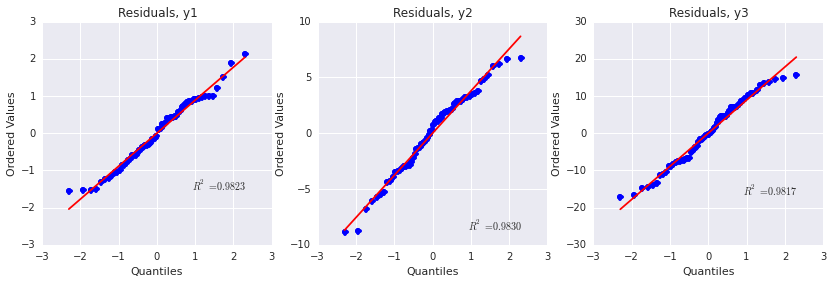

In [216]:
import seaborn as sns
import scipy.stats as stats
import pylab

# Quantify goodness of fit

fig = figure(figsize=(14,4))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

r1 = y1 - est1.predict(x)
r2 = y2 - est2.predict(x)
r3 = y3 - est3.predict(x)

stats.probplot(r1, dist="norm", plot=ax1)
ax1.set_title('Residuals, y1')

stats.probplot(r2, dist="norm", plot=ax2)
ax2.set_title('Residuals, y2')

stats.probplot(r3, dist="norm", plot=ax3)
ax3.set_title('Residuals, y3')

pylab.show()

It's pretty evident that there are no significant trends being missed by the models. 

Another thing we can look at is the normalized error: what are the values? How are they distributed? A kernel density estimate (KDE) plot, which is a smoothed histogram, shows the probability distribution of the normalized residual errors. As expected, they're bunched pretty close to zero. There are some bumps far from zero, but as we saw from the quantile-quantile plots above, these residuals are distributed the same way normal, random variables are distributed; there's no systematic bias there.

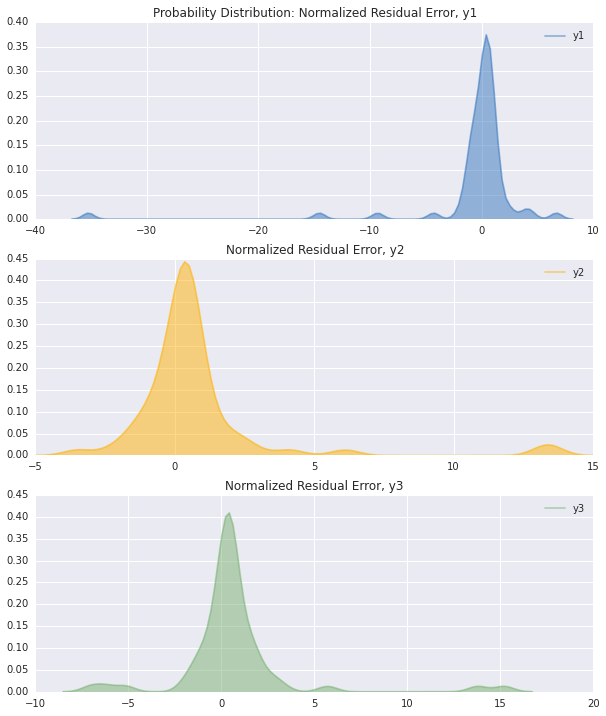

In [229]:
fig = figure(figsize=(10,12))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
axes = [ax1,ax2,ax3]

colors = sns.xkcd_palette(["windows blue", "amber", "faded green", "dusty purple","aqua blue"])

normed_resids = [r1/y1, r2/y2, r3/y3]

for (dataa, axx, colorr) in zip(normed_resids,axes,colors):
    sns.kdeplot(dataa, bw=0.5, ax=axx, color=colorr, shade=True, alpha=0.5);

ax1.set_title('Probability Distribution: Normalized Residual Error, y1')
ax2.set_title('Normalized Residual Error, y2')
ax3.set_title('Normalized Residual Error, y3')


Box and Draper next report aggregated experiment results, by computing the mean effect for the regressed variables. This is simple to do with Pandas, by grouping the data by each variable, and applying the mean function on all of the results. The code looks like this:

In [230]:
# Our original regression variables
xlabs = ['x2','x3','x4','x5','x6']
print doe.groupby(xlabs)[ylabs].mean()

                      y1         y2         y3
x2 x3 x4 x5 x6                                
-1 -1 -1 -1 -1 -2.113273  -9.775620 -24.687465
             1 -1.399746 -10.406277 -11.390568
          1 -1 -0.126796  -4.846614 -11.871364
             1  0.711381  -1.548306  -1.499686
       1 -1 -1 -0.229942  -8.346941 -14.362337
             1 -0.284790   0.270072 -14.482100
          1 -1 -0.546160  -4.443557   0.781152
             1  0.723659   0.940465   4.418968
    1 -1 -1 -1 -0.855716  -4.456834 -13.817349
             1  0.485757   3.313902  -5.572902
          1 -1  0.253573   1.898159  -5.082346
             1  1.165624   7.608581   4.191176
       1 -1 -1 -0.005515  -1.150630   0.510188
             1  0.880652   0.832691   9.142646
          1 -1  2.481403   5.408367   2.758770
             1  1.352338   1.299536   8.192491
 1 -1 -1 -1 -1 -0.895039  -5.996650  -7.841217
             1 -0.119157  -7.123183  -3.681290
          1 -1 -0.306797   2.087016 -12.520155
             

In [231]:
# If we decided to go for a smaller variable set
xlabs = ['x2','x3','x4','x6']
print doe.groupby(xlabs)[ylabs].mean()

                   y1        y2         y3
x2 x3 x4 x6                               
-1 -1 -1 -1 -1.120035 -7.311117 -18.279415
          1 -0.344182 -5.977292  -6.445127
       1 -1 -0.388051 -6.395249  -6.790592
          1  0.219434  0.605268  -5.031566
    1 -1 -1 -0.301071 -1.279338  -9.449848
          1  0.825691  5.461242  -0.690863
       1 -1  1.237944  2.128868   1.634479
          1  1.116495  1.066114   8.667568
 1 -1 -1 -1 -0.600918 -1.954817 -10.180686
          1  0.637103 -1.184429   1.666650
       1 -1  0.957073  2.473099  -2.878199
          1  1.824096  5.539736  10.074092
    1 -1 -1  0.161463 -2.827073   3.994286
          1  1.702992  5.872926   7.621108
       1 -1  1.316743  5.784515   4.603667
          1  2.272896  8.486038  24.296647


This functionality can also be used to determine the variance in all of the experimental observations being aggregated:

In [232]:
print doe.groupby(xlabs)[ylabs].var()

                   y1         y2          y3
x2 x3 x4 x6                                 
-1 -1 -1 -1  2.347820  19.382011  117.032487
          1  2.195945  32.470741  175.560640
       1 -1  0.104544  17.110446   82.212578
          1  1.374590   6.871747  191.004917
    1 -1 -1  1.437720  33.246032  118.512702
          1  1.902289   9.198926   61.688942
       1 -1  2.133005  16.855822  171.231799
          1  0.673717  11.926936   86.226929
 1 -1 -1 -1  0.238202  36.167190   37.378547
          1  1.183717  75.107867  100.298642
       1 -1  3.908928  14.548787  121.173029
          1  1.238099  30.060309   40.246346
    1 -1 -1  0.072674  13.390299  148.431325
          1  0.714831   4.748059  266.887505
       1 -1  1.772294  14.238270  123.795402
          1  1.296766  10.995265   84.647162


Or even the number of experimental observations being aggregated!

In [233]:
print doe.groupby(xlabs)[ylabs].count()

             y1  y2  y3
x2 x3 x4 x6            
-1 -1 -1 -1   4   4   4
          1   4   4   4
       1 -1   4   4   4
          1   4   4   4
    1 -1 -1   4   4   4
          1   4   4   4
       1 -1   4   4   4
          1   4   4   4
 1 -1 -1 -1   4   4   4
          1   4   4   4
       1 -1   4   4   4
          1   4   4   4
    1 -1 -1   4   4   4
          1   4   4   4
       1 -1   4   4   4
          1   4   4   4


We can convert these dataframes of averages, variances, and counts into data for plotting. For example, if we want to make a histogram of every value in the groupby dataframe, we can use the ```.values``` method, so that this:

    doe.gorupby(xlabs)[ylabs].mean()

becomes this:


    doe.groupby(xlabs)[ylabs].mean().values


This $M \times N$ array can then be flattened into a vector using the ```ravel()``` method from numpy:

    ravel( doe.groupby(xlabs)[ylabs].mean().values )

The resulting data can be used to generate histograms, as shown below:

Grouping responses by interaction x2-x3-x4-x6


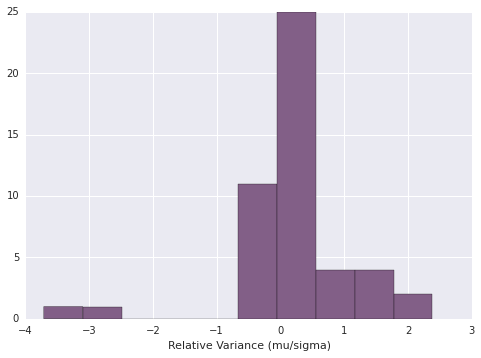

In [255]:
# Histogram of means of response values, grouped by xlabs

print "Grouping responses by interaction %s"%( "-".join(xlabs) )
dat = ravel(doe.groupby(xlabs)[ylabs].mean().values) / ravel(doe.groupby(xlabs)[ylabs].var().values)
plt.hist(dat, 10, normed=False, color=colors[3]);
plt.xlabel('Relative Variance (mu/sigma)')

Grouping responses by interaction x2-x3-x4-x6


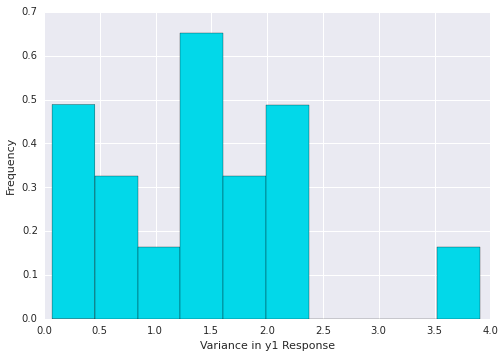

In [259]:
# Histogram of variances of response values, grouped by xlabs

print "Grouping responses by interaction %s"%( "-".join(xlabs) )
dat = ravel(doe.groupby(xlabs)['y1'].var().values)
plt.hist(dat, normed=True, color=colors[4]);
plt.xlabel('Variance in y1 Response');
plt.ylabel('Frequency');